**Digit Recognition using MNIST Dataset on Tensorflow**

The following is the code for Digit Recognition using MNIST Dataset. Convolutional Neural Network Model is used for training. The code below consists of three main parts:

* Data Loading and Pre-processing
* Model Building
* Evaluation of Model

In [1]:
import numpy as np
import pandas.util.testing as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import scipy
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.keras.datasets import mnist

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  


**Data Loading**

Tensorflow Datasets provides a collection of ready-to-use dataset and MNIST is one of them. This dataset consists of train set and test set. The train set consists of 60,000 images of 28x28 pixels size and test set consists of 10,000 images.

In [2]:
#Load training and testing datasets
(X_train_orig, Y_train_orig), (X_test_orig, Y_test_orig) = mnist.load_data()

In [3]:
#Print the shapes of training and testing datasets
print('MNIST Dataset Shape: ')
print('X_train: ',str(X_train_orig.shape))
print('Y_train: ',str(Y_train_orig.shape))
print('X_test: ',str(X_test_orig.shape))
print('Y_test: ',str(Y_test_orig.shape))

MNIST Dataset Shape: 
X_train:  (60000, 28, 28)
Y_train:  (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


**Data pre-processing**



In [4]:
# check data types
X_train_orig.dtype, Y_train_orig.dtype, X_test_orig.dtype, Y_test_orig.dtype

(dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('uint8'))

In [5]:
Y_train_orig = Y_train_orig.astype('int')
Y_test_orig = Y_test_orig.astype('int')
Y_train_orig.dtype,  Y_test_orig.dtype

(dtype('int64'), dtype('int64'))

(60000,)
<class 'numpy.ndarray'>
[[   0 5923]
 [   1 6742]
 [   2 5958]
 [   3 6131]
 [   4 5842]
 [   5 5421]
 [   6 5918]
 [   7 6265]
 [   8 5851]
 [   9 5949]]
The mean amount of elements per class is 6000.0
The standard deviation in the element per class distribution is 339.5051955092555


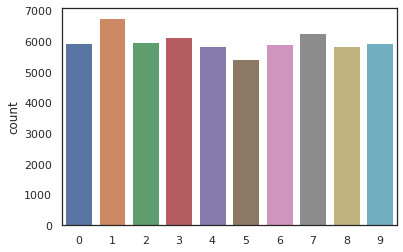

In [6]:
# mean and standard deviation of Classes
sns.set(style='white', context='notebook', palette='deep')

# plot how many images there are in each class
sns.countplot(Y_train_orig)

print(Y_train_orig.shape)
print(type(Y_train_orig))

# array with each class and its number of images
unique , counts = np.unique(Y_train_orig, return_counts=True)
print(np.asarray((unique, counts)).T)

# mean and std
cls_mean = np.mean(counts)
cls_std = np.std(counts,ddof=1)

print("The mean amount of elements per class is", cls_mean)
print("The standard deviation in the element per class distribution is", cls_std)


if cls_std > cls_mean * (0.6827 / 2):
    print("The standard deviation is high")

In [7]:
# Check nulls and missing values

print(np.sum(np.isnan(X_train_orig)))
print(np.sum(np.isnan(X_test_orig)))
print(np.sum(np.isnan(Y_train_orig)))
print(np.sum(np.isnan(Y_test_orig)))

0
0
0
0


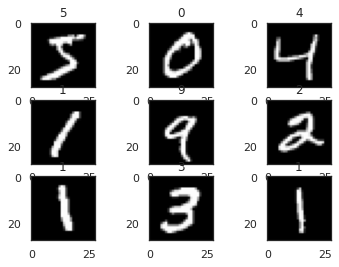

In [8]:
# Visualising the dataset

for index in range(0,9):
  plt.subplot(330+(index+1))
  plt.imshow(X_train_orig[index], cmap = 'gray')
  plt.title(str(Y_train_orig[index]))

In [9]:
# Reshape inputs to give 1 channel
X_train_orig = X_train_orig.reshape(X_train_orig.shape[0],28,28,1)
X_test_orig = X_test_orig.reshape(X_test_orig.shape[0],28,28,1)

# Convert values to float
X_train_orig = X_train_orig.astype('float32')
X_test_orig = X_test_orig.astype('float32')

# Normalize values between 0-1 as CNN converges faster with smaller values
X_train = X_train_orig / 255.0
X_test = X_test_orig / 255.0

# Perform one hot encoding
Y_train = np.eye(10)[Y_train_orig.reshape(-1)] 
Y_test = np.eye(10)[Y_test_orig.reshape(-1)]

print('Number of training examples: ',str(X_train.shape[0]))
print('Number of testing examples: ',str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

Number of training examples:  60000
Number of testing examples:  10000
X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)
X_test shape: (10000, 28, 28, 1)
Y_test shape: (10000, 10)


**Building CNN Model in Tensorflow** 

**1) Creating Placeholders**

In Tensorflow, placeholders should be created for input data that will be fed into the model while running the session.

In [10]:
# Create a Placeholder for input data that will be fed into model while running the session
def placeholders(n_h0, n_w0, n_c0, n_y):
    """
    Creating placeholders for tensorflow session
    """
    X = tf.compat.v1.placeholder(tf.float32, shape = [None,n_h0,n_w0,n_c0])
    Y = tf.compat.v1.placeholder(tf.float32, shape = [None,n_y])
    return X, Y

In [11]:
# Test placeholder function
tf.compat.v1.disable_eager_execution()
X, Y = placeholders(128,128,32,10)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(None, 128, 128, 32), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(None, 10), dtype=float32)


**2) Initializing Parameters**

We initialize the weight/filters W1 and W2 using tf.keras.initializers.GlorotNormal() . The bias avriables need not be initialised as they are taken care off in tensorflow. Also, filter initialization needs to be done only for Conv2D functions as tensorflow initializes the layers for fully connected part automatically. The filter shape is represented as [n$_{fh}$, n$_{fw}$, n$_{fc}$, n$_f$].
Where,

n$_{fh}$ - filter height

n$_{fw}$ - filter width

n$_{fc}$ - filter channels

n$_f$ - total number of filters

In [12]:
# Initialize parameters
# It is a two layer model.
def param_initialize(filter1, filter2):
    #tf.set_random_seed(1)
    W1 = tf.compat.v1.get_variable("W1",filter1, initializer = tf.keras.initializers.GlorotNormal())
    W2 = tf.compat.v1.get_variable("W2",filter2, initializer = tf.keras.initializers.GlorotNormal())
    parameters = {"W1": W1, "W2": W2}
    return parameters

In [13]:
# Test Parameter Initialization function
tf.compat.v1.reset_default_graph()
with tf.compat.v1.Session() as sess_test:
    parameters = param_initialize([4,4,3,8],[2,2,8,16])
    init = tf.compat.v1.global_variables_initializer()
    sess_test.run(init)
    print("W1[1,1,1] = \n" + str(parameters["W1"].eval()[1,1,1]))
    print("W1.shape: " + str(parameters["W1"].shape))
    print("\n")
    print("W2[1,1,1] = \n" + str(parameters["W2"].eval()[1,1,1]))
    print("W2.shape: " + str(parameters["W2"].shape))

W1[1,1,1] = 
[ 0.16509756 -0.0401838   0.19732484 -0.04658141 -0.02660793  0.09318393
  0.02731427  0.04729046]
W1.shape: (4, 4, 3, 8)


W2[1,1,1] = 
[-0.12830433  0.10876855  0.14363368  0.02441129 -0.18385738 -0.01331089
 -0.22861822  0.25475466  0.06114589  0.2029646  -0.03001172 -0.12799622
  0.28219405  0.12934925  0.27037993  0.11447636]
W2.shape: (2, 2, 8, 16)


**3) Forward Propagation**

In Tensorflow, there are built-in functions to implement Convolution Steps:


*   **tf.nn.conv2d(X,W,strides = [1,s,s,1], padding = 'SAME')** : This function performs 2D convolution of input X of dimension [batches , n$_{h}$, n$_{w}$, n$_{c}$] (n$_{h}$ and n$_{w}$ are height and width of input and n$_{c}$ are input channels) and of weight/filter of dimension [n$_{fh}$, n$_{fw}$, n$_{fc}$, n$_f$]. The third parameter represents the strides for each dimension of input, hence it is taken as 1 for batches and number of channels.
*   **tf.nn.relu(Z)** : This function computers element-wise Relu of Z where Z can be of any shape.
*   **tf.nn.max_pool(A, k = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME')** : This function, performs max pooling over each window given an input A, window size (f,f) and stride (s,s). Max pooling is generally operated on a single example and single channel at a time and hence the first value and fourth value in k and strides parameters of this function are 1. 
*   **tf.keras.layers.Flatten()** : This function flattens the input without affecting the batch size. So, if the input is of shape (m,h,w,c) then the function gives an output of shape (m,k) where k = h * w * c (product of all dimension sizes except first dimension). 
*   **tf.keras.layers.Dense()** : Dense implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True).

Thus, the CNN Model architecture for Training is given as:
CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE -> OUTPUT



In [14]:
# Forward Propogation 
def forward_propogation(X, parameters):
    """
    Implements forward propogation for the model
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    """
    # Retrive weight parameters from the dictionary
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: filer W1, stride = 1, padding = SAME
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window = 4x4 , stride = 2, padding = SAME
    P1 = tf.nn.max_pool(A1, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    # CONV2D: filter W2, stride = 1, padding = SAME
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window = 2x2, stride = 2, padding = SAME
    P2 = tf.nn.max_pool(A2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    # FLATTEN
    # = tf.contrib.layers.flatten(P2)
    F = tf.keras.layers.Flatten()(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 10 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.keras.layers.Dense(10)(F)
    
    return Z3
    

In [15]:
# Testing the Forward Propogation function
tf.compat.v1.reset_default_graph()

with tf.compat.v1.Session() as sess:
    X, Y = placeholders(28, 28, 1, 10)
    parameters = param_initialize([4,4,1,8],[2,2,8,16])
    Z3 = forward_propogation(X, parameters)
    init = tf.compat.v1.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,28,28,1), Y: np.random.randn(2,10)})
    print("Z3 = \n" + str(a))

Z3 = 
[[ 0.7254764  -0.74872184  0.2624486   0.30163106  0.9594699   0.45770848
  -0.82081985  0.43590882 -0.59378934 -0.12223189]
 [ 0.50848985 -0.9062246  -0.3395081   0.27760237  1.4682311   0.46184656
  -1.6328274   0.71381664 -0.8447888  -0.6744604 ]]


**4) Compute Cost**

Cost Function helps neural network see see how much the model's predictions differ from the correct labels. By adjusting the weights of the network to reduce the cost, the neural network can improve its predictions. 


* Softmax is used to format outputs so that they can be used for classification. It assigns a value between 0 and 1 for each category, where the sum of all prediction values (across all possible categories) equals 1.
* Cross Entropy is compares the model's predicted classifications with the actual labels and results in a numerical value representing the "loss" of the model's predictions.
* "Logits" are the result of multiplying the weights and adding the biases. Logits are passed through an activation function (such as a relu), and the result is called the "activation."
* The function is named softmax_cross_entropy_with_logits takes logits as input (and not activations); then uses the model to predict using softmax, and then compares the predictions with the true labels using cross entropy. These are done with a single function to optimize the calculations.


In [16]:
# Compute Cost
def compute_cost(Z3,Y):
    cost = tf.reduce_mean(tf.compat.v1.nn.softmax_cross_entropy_with_logits_v2(logits = Z3, labels = Y))
    return cost

In [17]:
#Testing the cost function
tf.compat.v1.reset_default_graph()

with tf.compat.v1.Session() as sess:
    np.random.seed(1)
    X, Y = placeholders(28, 28, 1, 10)
    parameters = param_initialize([4,4,1,8],[2,2,8,16])
    Z3 = forward_propogation(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.compat.v1.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,28,28,1), Y: np.random.randn(4,10)})
    print("cost = " + str(a))

cost = 6.3592486


In [18]:
def random_mini_batches(X, Y, mini_batch_size = 32):
    """Creates a list of random minibatches from (X, Y)"""
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]
    

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

**5) Model**

Finally merge all the functions to build the model that will be trained of MNIST dataset. 

*   **Optimizer** : Adam optimizer is used to minimize the cost function. Learning rate is set to 0.01 .
*   **Minibtaches** : The training data is split into minibatches of size 64 (64 training examples in one minibatch). For implementing gradient descent, whole data needs to be processed first and it can be time consuming. Splitting the training set into minibatches allows gradient descent to make some progress even before we finish processing entire data. And when the training set in huge, minibatch gradient descent is much faster than batch gradient descent. 



In [19]:
# Building a Model to train MNIST dataset
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001,
          num_epochs = 15, minibatch_size = 32, print_cost = True):
    
    ops.reset_default_graph()                   # to be able to rerun the model without overwriting tf variables
    (m, n_h0, n_w0, n_c0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                  # To keep track of the cost
    
    #Create Placeholders of correct shape
    X, Y = placeholders(n_h0, n_w0, n_c0, n_y)
    #Initialize Parameters
    parameters = param_initialize([4,4,1,16],[2,2,16,32])
    #Forward Propogation : Build Tensorflow Graph for forward propogation
    Z3 = forward_propogation(X,parameters)
    #Add Cost Function to Tensorflow graph
    cost = compute_cost(Z3,Y)
    #Adam Optimizer that minimizes cost for Backpropogation
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss = cost)
    
    #Initialize all variables globally
    init = tf.compat.v1.global_variables_initializer()
    
    #Start a Session
    with tf.compat.v1.Session() as sess:
        
        sess.run(init)
        
        #Training loop
        for epoch in range(num_epochs):
            
            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) 
            # number of minibatches of size minibatch_size in the train set
            
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                _ , temp_cost = sess.run(fetches = [optimizer,cost], feed_dict = {X:minibatch_X, Y:minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost after every epoch
            if print_cost == True and epoch % 1 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
                
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        #print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters
        
    

Cost after epoch 0: 0.205662
Cost after epoch 1: 0.067756
Cost after epoch 2: 0.050854
Cost after epoch 3: 0.041859
Cost after epoch 4: 0.034217
Cost after epoch 5: 0.028705
Cost after epoch 6: 0.025723
Cost after epoch 7: 0.022118
Cost after epoch 8: 0.019210
Cost after epoch 9: 0.017414
Cost after epoch 10: 0.014877
Cost after epoch 11: 0.012600
Cost after epoch 12: 0.011435
Cost after epoch 13: 0.009722
Cost after epoch 14: 0.009395


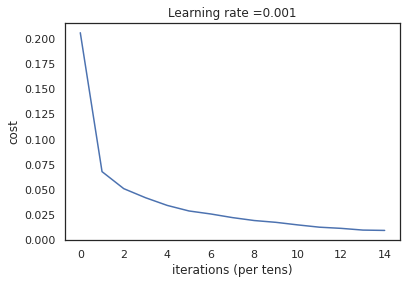

Train Accuracy: 0.99795
Test Accuracy: 0.9891


In [20]:
train_acc, test_acc, parameters = model(X_train, Y_train, X_test, Y_test)